# 46 访问网络服务

走到这里太不容易了，坚持。

为了激发你更多的兴趣，我还打算用几篇文章来说说Go语言的网络编程。不过，关于网络编程这个事情，恐怕早已庞大到用一两本专著都无法对它进行完整论述的地步了。

所以，我在这里说的东西只能算是个引子。只要这样能让你产生想去尝试的冲动，我就很开心了。

## 签到内容：socket与IPC

人们常常会使用Go语言去编写网络程序（当然了，这方面也是Go语言最为擅长的事情）。说到网络编程，我们就不得不提及socket。

`socket`，常被翻译为`套接字`，它应该算是网络编程世界中最为核心的知识之一了。关于`socket`，我们可以讨论的东西太多了，因此，我在这里只围绕着`Go`语言向你介绍一些关于它的基础知识。

所谓`socket`，是一种`IPC`方法。`IPC`是`Inter-Process Communication`的缩写，可以被翻译为`进程间通信`。顾名思义，`IPC`这个概念（或者说规范）主要定义的是多个进程之间，相互通信的方法。

这些方法主要包括：**系统信号（signal）、管道（pipe）、套接字 （socket）、文件锁（file lock）、消息队列（message queue）、信号灯（semaphore，有的地方也称之为信号量）等。**现存的主流操作系统大都对`IPC`提供了强有力的支持，尤其是`socket`。

你可能已经知道，`Go`语言对`IPC`也提供了一定的支持。

比如，在`os`代码包和`os/signal`代码包中就有针对系统信号的`API`。

又比如，`os.Pipe`函数可以创建命名管道，而`os/exec`代码包则对另一类管道（匿名管道）提供了支持。对于`socket`，Go语言与之相应的程序实体都在其标准库的`net`代码包中。

**毫不夸张地说，在众多的`IPC`方法中，`socket`是最为通用和灵活的一种。与其他的`IPC`方法不同，利用`socket`进行通信的进程，可以不局限在同一台计算机当中。**

**实际上，通信的双方无论存在于世界上的哪个角落，只要能够通过计算机的网卡端口以及网络进行互联，就可以使用`socket`。** 从这里可以看出socket夯爆了


支持`socket`的操作系统一般都会对外提供一套`API`。跑在它们之上的应用程序利用这套`API`，就可以与互联网上的另一台计算机中的程序、同一台计算机中的其他程序，甚至同一个程序中的其他线程进行通信。

例如，在Linux操作系统中，用于创建`socket`实例的API，就是由一个名为`socket`的系统调用代表的。这个系统调用是`Linux`内核的一部分。

>所谓的系统调用，你可以理解为特殊的C语言函数。它们是连接应用程序和操作系统内核的桥梁，也是应用程序使用操作系统功能的唯一渠道。

在Go语言标准库的`syscall`代码包中，有一个与这个`socket`系统调用相对应的函数。这两者的函数签名是基本一致的，它们都会接受三个`int`类型的参数，并会返回一个可以代表文件描述符的结果。

但不同的是，`syscall`包中的`Socket`函数本身是平台不相关的。在其底层，Go语言为它支持的每个操作系统都做了适配，这才使得这个函数无论在哪个平台上，总是有效的。

Go语言的`net`代码包中的很多程序实体，都会直接或间接地使用到`syscall.Socket`函数。

比如，我们在调用`net.Dial`函数的时候，会为它的两个参数设定值。其中的第一个参数名为`network`，它决定着Go程序在底层会创建什么样的`socket`实例，并使用什么样的协议与其他程序通信。

下面，我们就通过一个简单的问题来看看怎样正确地调用`net.Dial`函数。

**今天的问题是：`net.Dial`函数的第一个参数`network`有哪些可选值？**

这道题的**典型回答**是这样的。

`net.Dial`函数会接受两个参数，分别名为`network`和`address`，都是`string`类型的。

参数`network`常用的可选值一共有9个。这些值分别代表了程序底层创建的`socket`实例可使用的不同通信协议，罗列如下。
- "tcp"：代表TCP协议，其基于的IP协议的版本根据参数address的值自适应。
- "tcp4"：代表基于IP协议第四版的TCP协议。
- "tcp6"：代表基于IP协议第六版的TCP协议。
- "udp"：代表UDP协议，其基于的IP协议的版本根据参数address的值自适应。
- "udp4"：代表基于IP协议第四版的UDP协议。
- "udp6"：代表基于IP协议第六版的UDP协议。
- "unix"：代表Unix通信域下的一种内部socket协议，以SOCK_STREAM为socket类型。 //像本地的TCP
- "unixgram"：代表Unix通信域下的一种内部socket协议，以SOCK_DGRAM为socket类型。 // 像本地的UDP
- "unixpacket"：代表Unix通信域下的一种内部socket协议，以SOCK_SEQPACKET为socket类型。 // TCP可靠性与UDP边界感的结合

## 问题解析

为了更好地理解这些可选值的深层含义，我们需要了解一下`syscall.Socket`函数接受的那三个参数。

我在前面说了，这个函数接受的三个参数都是`int`类型的。这些参数所代表的**分别是想要创建的`socket`实例通信域、类型以及使用的协议。**

Socket的通信域主要有这样几个可选项：`IPv4`域、`IPv6`域和`Unix`域。

我想你应该能够猜出`IPv4`域、`IPv6`域的含义，它们对应的分别是基于`IP`协议第四版的网络，和基于`IP`协议第六版的网络。

现在的计算机网络大都是基于IP协议第四版的，但是由于现有`IP`地址的逐渐枯竭，网络世界也在逐步地支持`IP`协议第六版。

`Unix`域，指的是一种类`Unix`操作系统中特有的通信域。在装有此类操作系统的同一台计算机中，应用程序可以基于此域建立`socket`连接。

以上三种通信域分别可以由`syscall`代码包中的常量`AF_INET`、`AF_INET6`和`AF_UNIX`表示。

`Socket`的类型一共有4种，分别是：`SOCK_DGRAM`、`SOCK_STREAM`、`SOCK_SEQPACKET`以及`SOCK_RAW`。`syscall`代码包中也都有同名的常量与之对应。前两者更加常用一些。

`SOCK_DGRAM`中的“`DGRAM`”代表的是`datagram`，即数据报文。它是一种`有消息边界`，但没有逻辑连接的非可靠`socket`类型，我们熟知的基于`UDP`协议的网络通信就属于此类。

有消息边界的意思是，与`socket`相关的操作系统内核中的程序（以下简称内核程序）在发送或接收数据的时候是以`消息`为单位的。

你可以把消息理解为带有`固定边界`的一段数据。内核程序可以`自动地识别和维护这种边界`，并在必要的时候，把数据切割成一个一个的消息，或者把多个消息串接成连续的数据。如此一来，应用程序只需要面向消息进行处理就可以了。

所谓的有逻辑连接是指，通信双方在收发数据之前`必须先建立网络连接`。待连接建立好之后，双方就可以一对一地进行数据传输了。显然，基于`UDP`协议的网络通信并不需要这样，它是没有逻辑连接的。

只要应用程序指定好对方的网络地址，内核程序就可以`立即`把数据报文发送出去。这有优势，也有劣势。

- 优势是发送速度快，不长期占用网络资源，并且每次发送都可以指定不同的网络地址。

- 当然了，最后一个优势有时候也是劣势，因为这会使数据报文更长一些。其他的劣势有，无法保证传输的可靠性，不能实现数据的有序性，以及数据只能单向进行传输。

而`SOCK_STREAM`这个`socket`类型，恰恰与`SOCK_DGRAM`相反。它`没有`消息边界，但有逻辑连接，能够保证传输的可靠性和数据的有序性，同时还可以实现数据的双向传输。众所周知的基于`TCP`协议的网络通信就属于此类。

这样的网络通信传输数据的形式是`字节流`，而不是数据报文。字节流是以`字节`为单位的。**内核程序无法感知一段字节流中包含了多少个消息，以及这些消息是否完整，这完全需要应用程序自己去把控。**

不过，此类网络通信中的一端，总是会忠实地按照另一端发送数据时的字节排列顺序，接收和缓存它们。所以，**应用程序需要根据双方的约定去数据中查找消息边界**，并按照边界切割数据，仅此而已。

`syscall.Socket`函数的第三个参数用于表示`socket`实例所使用的协议。

通常，只要明确指定了前两个参数的值，我们就无需再去确定第三个参数值了，一般把它置为`0`就可以了。这时，内核程序会自行选择最合适的协议。

比如，当前两个参数值分别为`syscall.AF_INET`和`syscall.SOCK_DGRAM`的时候，内核程序会选择`UDP`作为协议。

又比如，在前两个参数值分别为`syscall.AF_INET6`和`syscall.SOCK_STREAM`时，内核程序可能会选择`TCP`作为协议。

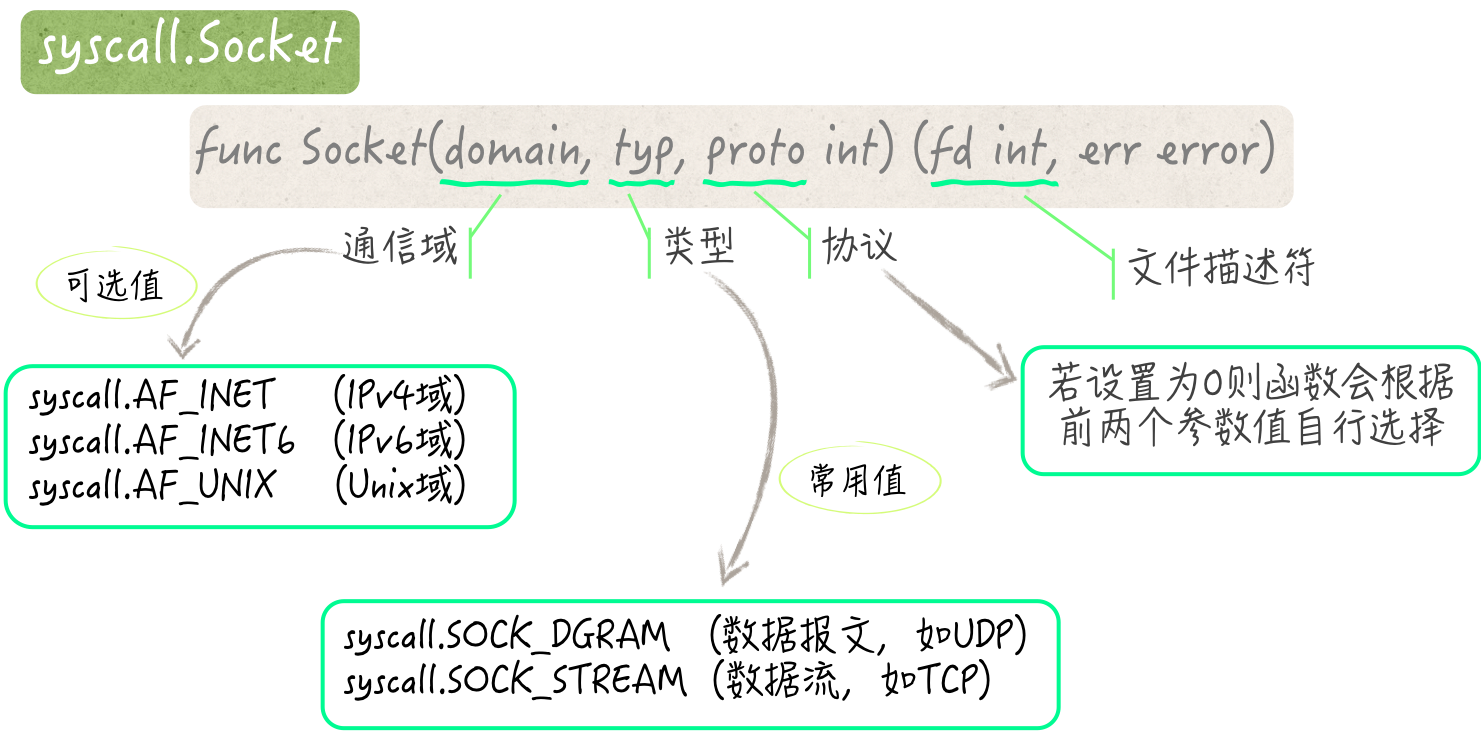
- （syscall.Socket函数一瞥）

不过，你也看到了，在使用`net`包中的高层次`API`的时候，我们连那前两个参数值都无需给定，只需要把前面罗列的那些字符串字面量的其中一个，作为`network`参数的值就好了。

当然，如果你在使用这些`API`的时候，能够想到我在上面说的这些基础知识的话，那么一定会对你做出正确的判断和选择有所帮助。

## 知识扩展

**问题1：调用net.DialTimeout函数时给定的超时时间意味着什么？**
简单来说，这里的超时时间，代表着函数为网络连接建立完成而等待的最长时间。这是一个相对的时间。它会由这个函数的参数`timeout`的值表示。

开始的时间点几乎是我们调用`net.DialTimeout`函数的那一刻。在这之后，时间会主要花费在“解析参数`network`和`address`的值”，以及“创建`socket`实例并建立网络连接”这两件事情上。

不论执行到哪一步，只要在绝对的超时时间达到的那一刻，网络连接还没有建立完成，该函数就会**返回一个代表了I/O操作超时的错误值。**

值得注意的是，在解析`address`的值的时候，函数会确定网络服务的`IP`地址、端口号等必要信息，并在需要时访问`DNS`服务。

另外，如果解析出的`IP`地址有多个，那么函数会**串行**或**并发**地尝试建立连接。但无论用什么样的方式尝试，函数总会以最先建立成功的那个连接为准。

同时，它还会根据超时前的剩余时间，去设定针对每次连接尝试的超时时间，以便让它们都有适当的时间执行。

再多说一点。在`net`包中还有一个名为`Dialer`的结构体类型。该类型有一个名叫`Timeout`的字段，它与上述的`timeout`参数的含义是完全一致的。实际上，`net.DialTimeout`函数正是利用了这个类型的值才得以实现功能的。

`net.Dialer`类型值得你好好学习一下，尤其是它的每个字段的功用以及它的`DialContext`方法。

## 总结

我们今天提及了使用Go语言进行网络编程这个主题。作为引子，我先向你介绍了关于socket的一些基础知识。socket常被翻译为套接字，它是一种IPC方法。IPC可以被翻译为进程间通信，它主要定义了多个进程之间相互通信的方法。

Socket是IPC方法中最为通用和灵活的一种。与其他的方法不同，利用socket进行通信的进程可以不局限在同一台计算机当中。

只要通信的双方能够通过计算机的网卡端口，以及网络进行互联就可以使用`socket`，无论它们存在于世界上的哪个角落。

支持`socket`的操作系统一般都会对外提供一套`API`。Go语言的`syscall`代码包中也有与之对应的程序实体。其中最重要的一个就是`syscall.Socket`函数。

不过，syscall包中的这些程序实体，对于普通的Go程序来说都属于底层的东西了，我们通常很少会用到。一般情况下，我们都会使用`net`代码包及其子包中的`API`去编写网络程序。

`net`包中一个很常用的函数，名为`Dial`。**这个函数主要用于连接网络服务。它会接受两个参数，你需要搞明白这两个参数的值都应该怎么去设定。**

尤其是`network`参数，它有很多的可选值，其中最常用的有9个。这些可选值的背后都代表着相应的`socket`属性，包括通信域、类型以及使用的协议。一旦你理解了这些socket属性，就一定会帮助你做出正确的判断和选择。

与此相关的一个函数是`net.DialTimeout`。我们在调用它的时候需要设定一个超时时间。这个超时时间的含义你是需要搞清楚的。

通过它，我们可以牵扯出这个函数的一大堆实现细节。另外，还有一个叫做`net.Dialer`的结构体类型。这个类型其实是前述`两个函数的底层实现`，值得你好好地学习一番。

以上，就是我今天讲的主要内容，它们都是关于怎样访问网络服务的。你可以从这里入手，进入Go语言的网络编程世界。

## 思考题：
今天的思考题也与超时时间有关。在你调用了net.Dial等函数之后，如果成功就会得到一个代表了网络连接的net.Conn接口类型的值。我的问题是：怎样在net.Conn类型的值上正确地设定针对读操作和写操作的超时时间？

net.Conn类型有3个可用于设置超时时间的方法，分别是：SetDeadline、SetReadDeadline和SetWriteDeadline。

这三个方法的签名是一模一样的，只是名称不同罢了。它们都接受一个time.Time类型的参数，并都会返回一个error类型的结果。其中的SetDeadline方法是用来同时设置读操作超时和写操作超时的。

有一点需要特别注意，这三个方法都会针对任何正在进行以及未来将要进行的相应操作进行超时设定。

因此，如果你要在一个循环中进行读操作或写操作的话，最好在每次迭代中都进行一次超时设定。

否则，靠后的操作就有可能因触达超时时间而直接失败。另外，如果有必要，你应该再次调用它们并传入`time.Time`类型的零值来表达不再限定超时时间。